# PyTorch Implementation of the paper 'Deep k-Nearest Neighbors'


                                                                                                                                                                                                                                                                                      This notebook contains a PyTorch implementation of the Deep k-Nearest Neighbors method introduced by Papernot & McDaniel (2018), which makes it possible to receive confidence scores for Deep Neural Network based predictions, that are more reliable than softmax scores. The paper can be found [here](https://arxiv.org/abs/1803.04765). The autors have also provided a basic implementation Tensorflow, which can be found [here](https://github.com/tensorflow/cleverhans/blob/master/cleverhans/model_zoo/deep_k_nearest_neighbors/dknn.py). However, this implementation is outdated. Hence, re-implemented the code here (in PyTorch).

First of all, a few package need to be installed. Besides Pytorch (pip packages torch and torchvision) we also need to install falconn and faiss. These two packages were used by Papernot and McDaniel to find the k-Nearest-Neighbors in high-dimensional spaces through local sensitive hashing (LSH). If you want to find our more about local sensitive hashing you can take a look [here](https://towardsdatascience.com/understanding-locality-sensitive-hashing-49f6d1f6134), [here](https://blog.mayflower.de/6498-lsh-nearest-neighbour-search.html), [here](https://www.youtube.com/watch?v=356GoYkmYKg&list=PLBv09BD7ez_6xoNh_luPdBmDCIHOQ3j7F) and [here](https://www.youtube.com/watch?v=gHdbqsDK9YY&list=PLBv09BD7ez_48heon5Az-TsyoXVYOJtDZ). However, I need to mention that falconn seems not to be under development anymore. Hence, someone might want to switch to another library providing local sensitive hashing in the future.

In [ ]:
          ! apt-get install libomp-dev

! pip uninstall torch torchvision -y
! pip install torch==1.4.0 torchvision==0.5.0
! pip install falconn==1.3.1
! pip install faiss==1.5.3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 2s (123 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpacking libomp5:amd64 (5.0.1-1) ...
Se

In [ ]:
!pip install numpy==1.16.1

     |████████████████████████████████| 17.3MB 189kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.16.1 which is incompatible.
ERROR: pyarrow 3.0.0 has requirement numpy>=1.16.6, but you'll have numpy 1.16.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: astropy 4.2.1 has requirement numpy>=1.17, but you'll have numpy 1.16.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


In [ ]:

%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

try:
  import secml
except ImportError:
  %pip install git+https://gitlab.com/secml/secml

Next, let's load the required modules from the packages. Furthermore, for reproducibility reasons I also like to print out the package version that are used here and some GPU information if a GPU is available (since I only do the testing using MNIST a CPU should work here as well).

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision
from torchvision import transforms
import matplotlib
import matplotlib.pyplot as plt
import pickle
import numpy as np
import falconn
import faiss
import platform
import enum
import copy
from bisect import bisect_left
import warnings

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))
print('pickle version:      {}'.format(pickle.format_version))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

python version:      3.7.10
torch version:       1.4.0
torchvision version: 0.5.0
numpy version:       1.19.5
matplotlib version:  3.2.2
pickle version:      4.0
CUDA available:      True
cuDNN enabled:       True
num gpus:            1
gpu:                 Tesla K80


Put CUDNN to deterministic and set seed values for [reproducibility reasons](https://pytorch.org/docs/stable/notes/randomness.html).

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

random_seed = 0
torch.manual_seed(random_seed)
np.random.seed(random_seed)

Let's set some parameters for the Deep kNN.

In [ ]:
num_epochs = 10            # number of training epochs
batch_size_train = 50    # batch size for training
batch_size_test = 50    # batch size for testing
learning_rate = 0.001     # learning rate for training
calibset_size = 50       # size of the calibration set for DkNN
neighbors = 75            # number of nearest neighbors for DkNN
number_bits = 17          # number of bits for LSH for DkNN

log_interval = 10         # printing training statistics after 10 iterations

## Data

### Specify Dataset

Define data transform functions for training and test set.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

Define training and test set.

In [ ]:
train_x = np.load('clean_poisoned_X.npy')
train_y = np.load('clean_poisoned_Y.npy')

calib_x = np.load('calib_x.npy')
calib_y = np.load('calib_y.npy')

test_x = np.load('test_x.npy')
test_y = np.load('test_y.npy')

In [ ]:
def get_tensor_data(x,Y):
  c_data = torch.Tensor(x.reshape(-1,1,28,28))
  c_label = torch.Tensor(Y).long()
  dataset = TensorDataset(c_data,c_label)
  return dataset
# trainset = torch.utils.data.DataLoader(ds, batch_size=50, shuffle=False, num_workers=2)

In [ ]:
trainset = get_tensor_data(train_x,train_y)
calibset = get_tensor_data(calib_x,calib_y)
testset = get_tensor_data(test_x,test_y)

In [ ]:
# # Training set
# trainset = torchvision.datasets.MNIST(
#     root='./data', train=True, download=True, transform=transform
# )

# # Test set and calibration set
# orig_testset = torchvision.datasets.MNIST(
#     root='./data', train=False, download=True, transform=transform
# )
# orig_testset_size = len(orig_testset)

# testset_size = orig_testset_size - calibset_size
# testset, calibset = torch.utils.data.random_split(orig_testset, [testset_size, calibset_size])

Add poisoned data to the MNIST Train Set

In [ ]:
# poisoned_data = np.load('poisoned_data_X.npy')
# poisoned_data_label = np.load('poisoned_data_Y.npy')

# poisoned_data_x = torch.Tensor(poisoned_data.reshape(len(poisoned_data),28,28)).byte()
# poisoned_data_y = torch.Tensor(poisoned_data_label).long()

In [ ]:
# trainset.data = torch.cat((trainset.data,poisoned_data_x),dim=0)
# trainset.targets = torch.cat((trainset.targets,poisoned_data_y))

### Load Data

Create train, test and calibration data loader.

In [ ]:
# Create training data loader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=2
)

# Create test data loader
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=2
)

# Create calib data loader
calibloader = torch.utils.data.DataLoader(
    calibset, batch_size=calibset_size, shuffle=False, num_workers=2
)

In [ ]:
trainset

Print out the sizes of the datasets.

In [ ]:
print('trainset size: {}'.format(len(trainloader.dataset)))
print('testset size:  {}'.format(len(testloader.dataset)))
print('calibset size: {}'.format(len(calibloader.dataset)))

trainset size: 1050
testset size:  500
calibset size: 500


### Display Samples

In [ ]:
def show_samples(data, targets):
    data = data.numpy()
    print("tensor shape: " + str(data.shape))
    
    fig = plt.figure()
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()
        
        img = data * 0.3081 + 0.1307  # unnormalize
        plt.imshow(img[i][0], cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(targets[i]))
        
        plt.xticks([])
        plt.yticks([])

Load a few test images and display them.

tensor shape: (50, 1, 28, 28)


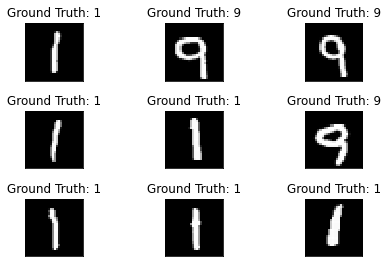

In [ ]:
dataiter = enumerate(testloader)
_, (sample_data, sample_targets) = next(dataiter)

show_samples(sample_data, sample_targets)

## Define Training and Test Functions

Let's define the functions for training and testing.

In [ ]:
def train(num_epochs, model, optim, crit, train_loader, test_loader):
    train_losses = []
    test_losses = []
    test_accs = []
    
    for epoch in range(1, num_epochs + 1):
        model, train_losses = train_one_epoch(epoch, model, optim, crit, train_loader, train_losses)
        test_losses, test_accs,_,_ = test(model, crit, test_loader, test_losses, test_accs)
        
    print('Finished Training')
    return train_losses, test_losses, test_accs
    

def train_one_epoch(epoch_num, model, optim, crit, data_loader, losses):
    model.train()
    running_loss = 0.0
    
    for batch_idx, data in enumerate(data_loader):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, targets = data

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        # Zero the parameter gradients
        optim.zero_grad()
        
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = crit(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        
        if batch_idx % log_interval == 0:
            dataset_size = len(data_loader.dataset)
            used_samples = batch_idx * len(inputs)
            train_progress = 100. * batch_idx / len(data_loader)
            avg_batch_loss = running_loss / log_interval
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_num, used_samples, dataset_size, train_progress, avg_batch_loss
            ))
            
            losses.append(avg_batch_loss)
            running_loss = 0.0
            
    return model, losses
     
    
def test(model, crit, data_loader, test_losses, test_accs):
    model.eval()
    correct = 0
    test_loss = 0
    pred_labels = []
    true_labels = []
    with torch.no_grad():
        for data in data_loader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            if use_cuda:
              inputs, targets = inputs.cuda(), targets.cuda()
            
            # Forward + loss + correct
            outputs = model(inputs)
            test_loss += crit(outputs, targets).item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
            # print('labels:',predicted.cpu().numpy().astype('int32').shape)

            pred_labels += list(predicted.cpu().numpy().astype('int32').flatten())
            true_labels += list(targets.cpu().numpy().astype('int32').flatten())

    dataset_size = len(data_loader.dataset)
    test_loss /= dataset_size
    acc = 100. * correct / dataset_size
    
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, dataset_size, acc
    ))
    
    return test_losses,test_accs,pred_labels,true_labels

## Network Architecture

Let's define the neural network based model architecture for MNIST, that has also been [used by Papernot and McDaniel](https://github.com/tensorflow/cleverhans/blob/master/cleverhans/model_zoo/deep_k_nearest_neighbors/dknn.py).

In [ ]:
class MnistNet(nn.Module):
    def __init__(self):
        super(MnistNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=8, stride=2, padding=3)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=6, stride=2)
        self.relu2 = nn.ReLU(True)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=5)
        self.relu3 = nn.ReLU(True)
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = x.view(-1, 128)
        x = self.fc(x)
        return x

## Model Training

Let's train the model.

In [ ]:
# Create Model
model = MnistNet()

if use_cuda:
    model.cuda()
    print('Using ', torch.cuda.device_count(), ' GPU(s)')

# Define Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Start Training
_, _, accs = train(num_epochs, model, optimizer, criterion, trainloader, testloader)

print()
print('Accuracies: {}'.format(accs))

Using  1  GPU(s)
Train Epoch: 1 [0/1050 (0%)]	Loss: 0.228818
Train Epoch: 1 [500/1050 (48%)]	Loss: 0.692764
Train Epoch: 1 [1000/1050 (95%)]	Loss: 0.407434

Test set: Avg. loss: 0.004305, Accuracy: 457/500 (91.40%)

Train Epoch: 2 [0/1050 (0%)]	Loss: 0.041239
Train Epoch: 2 [500/1050 (48%)]	Loss: 0.245698
Train Epoch: 2 [1000/1050 (95%)]	Loss: 0.241911

Test set: Avg. loss: 0.002257, Accuracy: 491/500 (98.20%)

Train Epoch: 3 [0/1050 (0%)]	Loss: 0.025021
Train Epoch: 3 [500/1050 (48%)]	Loss: 0.250420
Train Epoch: 3 [1000/1050 (95%)]	Loss: 0.174357

Test set: Avg. loss: 0.001121, Accuracy: 495/500 (99.00%)

Train Epoch: 4 [0/1050 (0%)]	Loss: 0.008627
Train Epoch: 4 [500/1050 (48%)]	Loss: 0.228799
Train Epoch: 4 [1000/1050 (95%)]	Loss: 0.196873

Test set: Avg. loss: 0.001290, Accuracy: 493/500 (98.60%)

Train Epoch: 5 [0/1050 (0%)]	Loss: 0.023115
Train Epoch: 5 [500/1050 (48%)]	Loss: 0.210300
Train Epoch: 5 [1000/1050 (95%)]	Loss: 0.186538

Test set: Avg. loss: 0.001391, Accuracy: 494/50

Put model in evaluation mode.

In [ ]:
model

MnistNet(
  (conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
model.eval()

if use_cuda:
    model.cuda()
    print('Using ', torch.cuda.device_count(), ' GPU(s)')

Using  1  GPU(s)


Let's test our model again to see again which accuracy we have finally reached.

In [ ]:
def test_final(model, data_loader):
    _, accs,_ ,_= test(model, criterion, data_loader, [], [])
    return accs[0]

Get the labels from DNN for the training set

In [ ]:
trainset.tensors[0].shape

torch.Size([1050, 1, 28, 28])

In [ ]:
# res = model(trainset.tensors[0].cuda().float())
# #trainset.data.cuda().float().reshape(-1,1,28,28)
# pred_label = np.argmax(res.cpu().detach().numpy(),axis=1)
# pred_label.shape
# train_labels = trainset.tensors[1].numpy()
# train_labels.shape
# Get the misclassified training points
# misclassified_train_idx = np.where(pred_label!=train_labels)[0]
# print('acc:',1-len(misclassified_train_idx)/len(train_labels))
# misclassified_train_data = trainset.tensors[0].numpy()[misclassified_train_idx]
# misclassified_train_label = trainset.tensors[0].numpy()[misclassified_train_idx]

## Get Activations

Now, let's try to get the activations of each layer when feeding the trained model with images. To see again which layers we have let's print the model architecture.

In [ ]:
result = test(model,criterion,trainloader,[],[])


Test set: Avg. loss: 0.003050, Accuracy: 1000/1050 (95.24%)



In [ ]:
model

MnistNet(
  (conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

Specify layers to be used for the DkNN.

In [ ]:
layers = {
    'relu1': model.relu1,
    'relu2': model.relu2,
    'relu3': model.relu3,
    'fc': model.fc
}

Define function to get activations.

In [ ]:
def get_activations(dataloader, model, layers):
    activations = {}
    activations['activations'] = {}
    activations['targets'] = None

    for layer_name in layers:
        print('## Fetching Activations from Layer {}'.format(layer_name))

        # Get activations for the data
        layer = layers[layer_name]
        activations['activations'][layer_name], targets = get_activations_from_layer(dataloader, model, layer)

        # Get the targets of that data
        if targets is not None:
            if activations['targets'] is not None:
                np.testing.assert_array_equal(activations['targets'], targets)
            else:
                activations['targets'] = targets

        print()

    return activations

def get_activations_from_layer(dataloader, model, layer):
    activations = []
    targets = []

    # Define hook for fetching the activations
    def hook(module, input, output):
        layer_activations = output.squeeze().detach().cpu().numpy()

        if len(layer_activations.shape) == 4:
            layer_activations = layer_activations.reshape(layer_activations.shape[0], -1)
        
        activations.append(layer_activations)

    handle = layer.register_forward_hook(hook)

    # Fetch activations
    for i, batch in enumerate(dataloader):
        print('Processing Batch {}'.format(i))
        

        if use_cuda:
            batch = [_batch.cuda() for _batch in batch]
            #batch = batch.cuda()
            

        _ = model(batch[0])

        if len(batch) > 1:
          targets.append(batch[1].detach().cpu().numpy())

    print("done!")

    # Remove hook
    handle.remove()

    # Return activations and targets
    activations = np.concatenate(activations)

    if targets:
        targets = np.hstack(targets)
    else:
        None

    return activations, targets

Test activation fetching.

In [ ]:
acts = get_activations(calibloader, model, layers)

## Fetching Activations from Layer relu1
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
done!

## Fetching Activations from Layer relu2
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
done!

## Fetching Activations from Layer relu3
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
done!

## Fetching Activations from Layer fc
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
done!



In [ ]:
print('targets: {}'.format(acts['targets'].shape))
print()

for layer in layers:
    print('## layer {}'.format(layer))
    print('activations: {}'.format(acts['activations'][layer].shape))
    print()

targets: (500,)

## layer relu1
activations: (500, 12544)

## layer relu2
activations: (500, 3200)

## layer relu3
activations: (500, 128)

## layer fc
activations: (500, 10)



# Deep kNN

Now, let's implement DkNN. The code is based on the original [code from Papernot and McDaniel](https://github.com/tensorflow/cleverhans/blob/master/cleverhans/model_zoo/deep_k_nearest_neighbors/dknn.py). It was converted to PyTorch.

In [ ]:
class NearestNeighbor:

    class BACKEND(enum.Enum):
        FALCONN = 1
        FAISS = 2

    def __init__(self, backend, dimension, neighbors, number_bits, nb_tables=None):
        assert backend in NearestNeighbor.BACKEND

        self._NEIGHBORS = neighbors
        self._BACKEND = backend

        if self._BACKEND is NearestNeighbor.BACKEND.FALCONN:
            self._init_falconn(dimension, number_bits, nb_tables)
        elif self._BACKEND is NearestNeighbor.BACKEND.FAISS:
            self._init_faiss(dimension)
        else:
            raise NotImplementedError

    def _init_falconn(self, dimension, number_bits, nb_tables):
        assert nb_tables >= self._NEIGHBORS

        # LSH parameters
        params_cp = falconn.LSHConstructionParameters()
        params_cp.dimension = dimension
        params_cp.lsh_family = falconn.LSHFamily.CrossPolytope
        params_cp.distance_function = falconn.DistanceFunction.EuclideanSquared
        params_cp.l = nb_tables
        params_cp.num_rotations = 2  # for dense set it to 1; for sparse data set it to 2
        params_cp.seed = 5721840
        params_cp.num_setup_threads = 0  # we want to use all the available threads to set up
        params_cp.storage_hash_table = falconn.StorageHashTable.BitPackedFlatHashTable

        # we build number_bits-bit hashes so that each table has
        # 2^number_bits bins; a rule of thumb is to have the number
        # of bins be the same order of magnitude as the number of data points
        falconn.compute_number_of_hash_functions(number_bits, params_cp)
        self._falconn_table = falconn.LSHIndex(params_cp)
        self._falconn_query_object = None
        self._FALCONN_NB_TABLES = nb_tables

    def _init_faiss(self, dimension):
        res = faiss.StandardGpuResources()
        self._faiss_index = faiss.GpuIndexFlatL2(res, dimension)

    def add(self, x):
        if self._BACKEND is NearestNeighbor.BACKEND.FALCONN:
            self._falconn_table.setup(x)
        elif self._BACKEND is NearestNeighbor.BACKEND.FAISS:
            self._faiss_index.add(x)
        else:
            raise NotImplementedError

    def find_knns(self, x, output):
        if self._BACKEND is NearestNeighbor.BACKEND.FALCONN:
            return self._find_knns_falconn(x, output)
        elif self._BACKEND is NearestNeighbor.BACKEND.FAISS:
            return self._find_knns_faiss(x, output)
        else:
            raise NotImplementedError

    def _find_knns_falconn(self, x, output):
        # Late falconn query_object construction
        # Since I suppose there might be an error
        # if table.setup() will be called after
        if self._falconn_query_object is None:
            self._falconn_query_object = self._falconn_table.construct_query_object()
            self._falconn_query_object.set_num_probes(self._FALCONN_NB_TABLES)

        missing_indices = np.zeros(output.shape, dtype=np.bool)

        for i in range(x.shape[0]):
            query_res = self._falconn_query_object.find_k_nearest_neighbors(x[i], self._NEIGHBORS)

            try:
                output[i, :] = query_res
            except:
                # mark missing indices
                missing_indices[i, len(query_res):] = True
                output[i, :len(query_res)] = query_res

        return missing_indices

    def _find_knns_faiss(self, x, output):
        neighbor_distance, neighbor_index = self._faiss_index.search(x, self._NEIGHBORS)

        missing_indices = neighbor_distance == -1
        d1 = neighbor_index.reshape(-1)

        output.reshape(-1)[np.logical_not(missing_indices.flatten())] = d1[np.logical_not(missing_indices.flatten())]

        return missing_indices


class DkNN:

    def __init__(self, model, nb_classes, neighbors, layers, trainloader, nearest_neighbor_backend, nb_tables=200, number_bits=17):
        """
        Implementation of the DkNN algorithm, see https://arxiv.org/abs/1803.04765 for more details
        :param model: model to be used
        :param nb_classes: the number of classes in the task
        :param neighbors: number of neighbors to find per layer
        :param layers: a list of layer names to include in the DkNN
        :param trainloader: data loader for the training data
        :param nearest_neighbor_backend: falconn or faiss to be used for LSH
        :param nb_tables: number of tables used by FALCONN to perform locality-sensitive hashing.
        :param number_bits: number of hash bits used by LSH.
        """
        print('---------- DkNN init')
        print()

        self.model = model
        self.nb_classes = nb_classes
        self.neighbors = neighbors
        self.layers = layers
        self.backend = nearest_neighbor_backend
        self.nb_tables = nb_tables
        self.number_bits = number_bits

        self.nb_cali = -1
        self.calibrated = False   

        # Compute training data activations
        activations = get_activations(trainloader, model, layers)
        self.train_activations = activations['activations']
        self.train_labels = activations['targets']

        # Build locality-sensitive hashing tables for training representations
        self.train_activations_lsh = copy.copy(self.train_activations)
        self.init_lsh()

    def init_lsh(self):
        """
        Initializes locality-sensitive hashing with FALCONN to find nearest neighbors in training data
        """
        self.query_objects = {} # contains the object that can be queried to find nearest neighbors at each layer
        self.centers = {} # mean of training data representation per layer (that needs to be substracted before NearestNeighbor)

        print("## Constructing the NearestNeighbor tables")

        for layer in self.layers:
            print("Constructing table for {}".format(layer))

            # Normalize all the lenghts, since we care about the cosine similarity
            self.train_activations_lsh[layer] /= np.linalg.norm(self.train_activations_lsh[layer], axis=1).reshape(-1, 1)

            # Center the dataset and the queries: this improves the performance of LSH quite a bit
            center = np.mean(self.train_activations_lsh[layer], axis=0)
            self.train_activations_lsh[layer] -= center
            self.centers[layer] = center

            # Constructing nearest neighbor table
            self.query_objects[layer] = NearestNeighbor(
                backend=self.backend,
                dimension=self.train_activations_lsh[layer].shape[1],
                number_bits=self.number_bits,
                neighbors=self.neighbors,
                nb_tables=self.nb_tables,
            )

            self.query_objects[layer].add(self.train_activations_lsh[layer])

        print("done!")
        print()


    def calibrate(self, calibloader):
        """
        Runs the DkNN on holdout data to calibrate the credibility metric
        :param calibloader: data loader for the calibration loader
        """
        print('---------- DkNN calibrate')
        print()

        # Compute calibration data activations
        self.nb_cali = len(calibloader.dataset)
        activations = get_activations(calibloader, self.model, self.layers)
        self.cali_activations = activations['activations']
        self.cali_labels = activations['targets']

        print("## Starting calibration of DkNN")

        cali_knns_ind, cali_knns_labels = self.find_train_knns(self.cali_activations)
        assert all([v.shape == (self.nb_cali, self.neighbors) for v in cali_knns_ind.values()])
        assert all([v.shape == (self.nb_cali, self.neighbors) for v in cali_knns_labels.values()])

        cali_knns_not_in_class = self.nonconformity(cali_knns_labels)
        cali_knns_not_in_l = np.zeros(self.nb_cali, dtype=np.int32)

        for i in range(self.nb_cali):
            cali_knns_not_in_l[i] = cali_knns_not_in_class[i, self.cali_labels[i]]

        cali_knns_not_in_l_sorted = np.sort(cali_knns_not_in_l)
        self.cali_nonconformity = np.trim_zeros(cali_knns_not_in_l_sorted, trim='f')
        self.nb_cali = self.cali_nonconformity.shape[0]
        self.calibrated = True

        print("DkNN calibration complete")

    def find_train_knns(self, data_activations):
        """
        Given a data_activation dictionary that contains a np array with activations for each layer,
        find the knns in the training data
        """
        knns_ind = {}
        knns_labels = {}

        for layer in self.layers:
            # Pre-process representations of data to normalize and remove training data mean
            data_activations_layer = copy.copy(data_activations[layer])
            nb_data = data_activations_layer.shape[0]
            data_activations_layer /= np.linalg.norm(data_activations_layer, axis=1).reshape(-1, 1)
            data_activations_layer -= self.centers[layer]

            # Use FALCONN to find indices of nearest neighbors in training data
            knns_ind[layer] = np.zeros((data_activations_layer.shape[0], self.neighbors), dtype=np.int32)
            knn_errors = 0

            knn_missing_indices = self.query_objects[layer].find_knns(data_activations_layer, knns_ind[layer])
            knn_errors += knn_missing_indices.flatten().sum()

            # Find labels of neighbors found in the training data
            knns_labels[layer] = np.zeros((nb_data, self.neighbors), dtype=np.int32)

            knns_labels[layer].reshape(-1)[
                np.logical_not(knn_missing_indices.flatten())
            ] = self.train_labels[
                knns_ind[layer].reshape(-1)[np.logical_not(knn_missing_indices.flatten())]                    
            ]

        return knns_ind, knns_labels

    def nonconformity(self, knns_labels):
        """
        Given an dictionary of nb_data x nb_classes dimension, compute the nonconformity of
        each candidate label for each data point: i.e. the number of knns whose label is
        different from the candidate label
        """
        nb_data = knns_labels[list(self.layers.keys())[0]].shape[0]
        knns_not_in_class = np.zeros((nb_data, self.nb_classes), dtype=np.int32)

        for i in range(nb_data):
            # Compute number of nearest neighbors per class
            knns_in_class = np.zeros((len(self.layers), self.nb_classes), dtype=np.int32)

            for layer_id, layer in enumerate(self.layers):
                knns_in_class[layer_id, :] = np.bincount(knns_labels[layer][i], minlength=self.nb_classes)

            # Compute number of knns in other class than class_id
            for class_id in range(self.nb_classes):
                knns_not_in_class[i, class_id] = np.sum(knns_in_class) - np.sum(knns_in_class[:, class_id])

        return knns_not_in_class

    def fprop(self, testloader):
        """
        Performs a forward pass through the DkNN on an numpy array of data
        """
        print('---------- DkNN predict')
        print()

        if not self.calibrated:
            raise ValueError("DkNN needs to be calibrated by calling DkNNModel.calibrate method once before inferring")

        # Compute test data activations
        activations = get_activations(testloader, self.model, self.layers)
        data_activations = activations['activations']
        _, knns_labels = self.find_train_knns(data_activations)

        # Calculate nonconformity
        knns_not_in_class = self.nonconformity(knns_labels)
        print('Nonconformity calculated')

        # Create predictions, confidence and credibility
        # _, _,creds = self.preds_conf_cred(knns_not_in_class)
        preds_knn, confs,creds = self.preds_conf_cred(knns_not_in_class)
        print('Predictions created')

        return creds, activations['targets'],preds_knn,confs

    def preds_conf_cred(self, knns_not_in_class):
        """
        Given an array of nb_data x nb_classes dimensions, use conformal prediction to compute
        the DkNN's prediction, confidence and credibility
        """
        nb_data = knns_not_in_class.shape[0]
        preds_knn = np.zeros(nb_data, dtype=np.int32)
        confs = np.zeros((nb_data, self.nb_classes), dtype=np.float32)
        creds = np.zeros((nb_data, self.nb_classes), dtype=np.float32)

        for i in range(nb_data):
            # p-value of test input for each class
            p_value = np.zeros(self.nb_classes, dtype=np.float32)

            for class_id in range(self.nb_classes):
                # p-value of (test point, candidate label)
                p_value[class_id] = (float(self.nb_cali) - bisect_left(self.cali_nonconformity, knns_not_in_class[i, class_id])) / float(self.nb_cali)

            preds_knn[i] = np.argmax(p_value)
            confs[i, preds_knn[i]] = 1. - np.sort(p_value)[-2]
            creds[i, preds_knn[i]] = p_value[preds_knn[i]]

        return preds_knn, confs, creds


def plot_reliability_diagram(confidence, labels):
    """
    Takes in confidence values (e.g. output of softmax or DkNN confidences) for
    predictions and correct labels for the data, plots a reliability diagram
    :param confidence: nb_samples x nb_classes with confidence scores
    :param labels: targets
    """
    assert len(confidence.shape) == 2
    assert len(labels.shape) == 1
    assert confidence.shape[0] == labels.shape[0]

    if confidence.max() <= 1.:
        # confidence array is output of softmax
        bins_start = [b / 10. for b in range(0, 10)]
        bins_end = [b / 10. for b in range(1, 11)]
        bins_center = [(b + .5) / 10. for b in range(0, 10)]
        preds_conf = np.max(confidence, axis=1)
        preds_l = np.argmax(confidence, axis=1)
    else:
        raise ValueError('Confidence values go above 1')

    print(preds_conf.shape, preds_l.shape)

    # Create var for reliability diagram (Will contain mean accuracies for each bin)
    reliability_diag = []
    num_points = []  # keeps the number of points in each bar

    # Find average accuracy per confidence bin
    for bin_start, bin_end in zip(bins_start, bins_end):
        above = preds_conf >= bin_start

        if bin_end == 1.:
            below = preds_conf <= bin_end
        else:
            below = preds_conf < bin_end

        mask = np.multiply(above, below)
        num_points.append(np.sum(mask))

        bin_mean_acc = max(0, np.mean(preds_l[mask] == labels[mask]))
        reliability_diag.append(bin_mean_acc)

    # Plot diagram
    assert len(reliability_diag) == len(bins_center)
    #print(reliability_diag)
    #print(bins_center)
    #print(num_points)

    fig, ax1 = plt.subplots()
    _ = ax1.bar(bins_center, reliability_diag, width=.1, alpha=0.8, edgecolor = "black")
    plt.xlim([0, 1.])
    ax1.set_ylim([0, 1.])

    ax2 = ax1.twinx()

    #print(sum(num_points))

    ax2.plot(bins_center, num_points, color='r', linestyle='-', linewidth=7.0)
    ax2.set_ylabel('Number of points in the data', fontsize=16, color='r')

    if len(np.argwhere(confidence[0] != 0.)) == 1:
        # This is a DkNN diagram
        ax1.set_xlabel('Prediction Credibility', fontsize=16)
    else:
        # This is a softmax diagram
        ax1.set_xlabel('Prediction Confidence', fontsize=16)

    ax1.set_ylabel('Prediction Accuracy', fontsize=16)
    ax1.tick_params(axis='both', labelsize=14)
    ax2.tick_params(axis='both', labelsize=14, colors='r')
    fig.tight_layout()
    plt.show()

Let's create a dataloader for training data that should be used to initialize the DkNN (shuffle must be false!). Then, initialize the DkNN.

In [ ]:
# Create training data loader for DkNN
trainloader_dknn = torch.utils.data.DataLoader(                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
    trainset, batch_size=batch_size_train, shuffle=False, num_workers=3
)

# Initialize DkNN
nb_classes_mnist = 10
dknn = DkNN(model, nb_classes_mnist, neighbors, layers, trainloader_dknn, NearestNeighbor.BACKEND.FALCONN)

---------- DkNN init

## Fetching Activations from Layer relu1
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
Processing Batch 10
Processing Batch 11
Processing Batch 12
Processing Batch 13
Processing Batch 14
Processing Batch 15
Processing Batch 16
Processing Batch 17
Processing Batch 18
Processing Batch 19
Processing Batch 20
done!

## Fetching Activations from Layer relu2
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
Processing Batch 10
Processing Batch 11
Processing Batch 12
Processing Batch 13
Processing Batch 14
Processing Batch 15
Processing Batch 16
Processing Batch 17
Processing Batch 18
Processing Batch 19
Processing Batch 20
done!

## Fetching Activations from Layer relu3
Processing Batch 0
Pr

Then, calibrate.

In [ ]:
dknn.calibrate(calibloader)

---------- DkNN calibrate

## Fetching Activations from Layer relu1
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
done!

## Fetching Activations from Layer relu2
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
done!

## Fetching Activations from Layer relu3
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
done!

## Fetching Activations from Layer fc
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
done!

## Starting calibration 

Run DkNN on train set 

Collect misclassified training points

White Box Attacks


In [1]:
def ifgsm(
    model,
    X,
    y,
    niters=10,
    epsilon=0.03,
    visualize=False,
    learning_rate=0.005,
    display=4,
    defense_model=False,
    setting="regular",
    dataset="cifar10",
    use_Inc_model = False,
):
    """Perform ifgsm attack with respect to model on images X with labels y
    Args:
        model: torch model with respect to which attacks will be computed
        X: batch of torch images
        y: labels corresponding to the batch of images
        niters: number of iterations of ifgsm to perform
        epsilon: Linf norm of resulting perturbation; scale of images is -1..1
        visualize: whether you want to visualize the perturbations or not
        learning_rate: learning rate of ifgsm
        display: number of images to display in visualization
        defense_model: set to true if you are using a defended model,
        e.g. ResNet18Defended, instead of the usual ResNet18
        setting: 'regular' is usual ifgsm, 'll' is least-likely ifgsm, and
        'nonleaking' is non-label-leaking ifgsm
        dataset: dataset the images are from, 'cifar10' | 'imagenet'
    Returns:
        The batch of adversarial examples corresponding to the original images
    """
    model.eval()
    out = None
    if defense_model:
        out = model(X)[0]
    else:
        out = model(X)
    y_ll = out.min(1)[1]  # least likely model output
    y_ml = out.max(1)[1]  # model label

    X_pert = X.clone()
    X_pert.requires_grad = True
    for i in range(niters):
        output_perturbed = None
        if defense_model:
            output_perturbed = model(X_pert)[0]
        else:
            output_perturbed = model(X_pert)

        y_used = y
        ll_factor = 1
        if setting == "ll":
            y_used = y_ll
            ll_factor = -1
        elif setting == "noleaking":
            y_used = y_ml

        loss = nn.CrossEntropyLoss()(output_perturbed, y_used)
        loss.backward()
        pert = ll_factor * learning_rate * X_pert.grad.detach().sign()

        # perform visualization
        if visualize is True and i == niters - 1:
            np_image = sow_images(X[:display].detach())
            np_delta = sow_images(pert[:display].detach())
            np_recons = sow_images(
                (X_pert.detach() + pert.detach()).clamp(-1, 1)[:display]
            )

            fig = plt.figure(figsize=(8, 8))
            fig.add_subplot(3, 1, 1)
            plt.axis("off")
            plt.imshow(np_recons)
            fig.add_subplot(3, 1, 2)
            plt.axis("off")
            plt.imshow(np_image)
            fig.add_subplot(3, 1, 3)
            plt.axis("off")
            plt.imshow(np_delta)
            plt.show()
        # end visualization

        # add perturbation
        X_pert = X_pert.detach() + pert
        X_pert.requires_grad = True

        # make sure we don't modify the original image beyond epsilon and clamp
        X_pert = renormalization(X, X_pert, epsilon, dataset=dataset, use_Inc_model=use_Inc_model)
        X_pert.requires_grad = True

    return X_pert


def fgsm(model, X, y, epsilon=0.01, **args):
    """Perform cifar 10 fgsm attack with respect to model on images X with labels y
    Args:
        model: torch model with respect to which attacks will be computed
        X: batch of torch images
        y: labels corresponding to the batch of images
        epsilon: Linf norm of resulting perturbation; scale of images is -1..1
    Returns:
        The batch of adversarial examples corresponding to the original images
    """
    if dataset != "cifar10":
        raise "fgsm as now does not support " + dataset

    X_pert = X.clone()
    X_pert.requires_grad = True
    output_perturbed = model(X_pert)
    loss = nn.CrossEntropyLoss()(output_perturbed, y)
    loss.backward()

    pert = epsilon * X_pert.grad.detach().sign()
    X_pert = X_pert.detach() + pert
    X_pert = X_pert.detach().clamp(X.min(), X.max())
    return X_pert



In [2]:
def ILA(
    model,
    X,
    X_attack,
    y,
    feature_layer,
    niters=10,
    epsilon=0.01,
    coeff=1.0,
    learning_rate=1,
    dataset="cifar10",
    use_Inc_model = False,
    with_projection=True,
):
    """Perform ILA attack with respect to model on images X with labels y
    Args:
        with_projection: boolean, specifies whether projection should happen
        in the attack
        model: torch model with respect to which attacks will be computed
        X: batch of torch images
        X_attack: starting adversarial examples of ILA that will be modified
        to become more transferable
        y: labels corresponding to the batch of images
        feature_layer: layer of model to project on in ILA attack
        niters: number of iterations of the attack to perform
        epsilon: Linf norm of resulting perturbation; scale of images is -1..1
        coeff: coefficient of magnitude loss in ILA attack
        visualize: whether you want to visualize the perturbations or not
        learning_rate: learning rate of the attack
        dataset: dataset the images are from, 'cifar10' | 'imagenet'
    Returns:
        The batch of modified adversarial examples, examples have been
        augmented from X_attack to become more transferable
    """
    X = X.detach()
    X_pert = torch.zeros(X.size()).cuda()
    X_pert.copy_(X).detach()
    X_pert.requires_grad = True

    def get_mid_output(m, i, o):
        global mid_output
        mid_output = o

    h = feature_layer.register_forward_hook(get_mid_output)

    out = model(X)
    mid_original = torch.zeros(mid_output.size()).cuda()
    mid_original.copy_(mid_output)

    out = model(X_attack)
    mid_attack_original = torch.zeros(mid_output.size()).cuda()
    mid_attack_original.copy_(mid_output)

    for _ in range(niters):
        output_perturbed = model(X_pert)

        # generate adversarial example by max middle layer pertubation
        # in the direction of increasing loss
        if with_projection:
            loss = Proj_Loss()(
                mid_attack_original.detach(), mid_output, mid_original.detach(), coeff
            )
        else:
            loss = Mid_layer_target_Loss()(
                mid_attack_original.detach(), mid_output, mid_original.detach(), coeff
            )

        loss.backward()
        pert = learning_rate * X_pert.grad.detach().sign()

        # minimize loss
        X_pert = X_pert.detach() + pert
        X_pert.requires_grad = True

        # make sure we don't modify the original image beyond epsilon
        X_pert = renormalization(X, X_pert, epsilon, dataset=dataset, use_Inc_model=use_Inc_model)
        X_pert.requires_grad = True

    h.remove()
    return X_pert


In [3]:
img_ifgsm = ifgsm(model, img, lbl, niters=opt.niters_baseline, dataset='clean_x.npy')

NameError: ignored